In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from models.model_fpgan import FPGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [41]:
data = pd.read_csv("D:/Datasets/heart_disease/heart_disease.csv")
#data = data.drop(columns=['id'])
data.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [42]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())

In [43]:
data.shape
data = data[:70000]

In [44]:
target = 'HeartDiseaseorAttack'

In [45]:
X = data.drop(columns=[target])
y = data[target]

In [46]:
model_ctgan = FPGANSynthesizer(epochs=20, verbose=True)
original_losses, tranformed_privacies, losses = model_ctgan.fit(data, rate=0.2)

Epoch 1, Loss G: -0.3109,Loss D: -1.6118
Epoch 2, Loss G: -0.4536,Loss D: -0.6216
Epoch 3, Loss G: -0.3644,Loss D: -0.6649
Epoch 4, Loss G: -0.3049,Loss D: -1.3058
Epoch 5, Loss G: -0.2880,Loss D: -1.1714
Epoch 6, Loss G: -0.2916,Loss D: -1.9398
Epoch 7, Loss G: -0.2880,Loss D: -2.2441
Epoch 8, Loss G: -0.2548,Loss D: -2.2563
Epoch 9, Loss G: -0.2512,Loss D: -2.5027
Epoch 10, Loss G: -0.2561,Loss D: -3.2112
Epoch 11, Loss G: -0.2378,Loss D: -3.1715
Epoch 12, Loss G: -0.2409,Loss D: -2.8570
Epoch 13, Loss G: -0.2263,Loss D: -3.7390
Epoch 14, Loss G: -0.1989,Loss D: -4.1940
Epoch 15, Loss G: -0.1975,Loss D: -4.7950
Epoch 16, Loss G: -0.1792,Loss D: -4.6241
Epoch 17, Loss G: -0.2124,Loss D: -4.3097
Epoch 18, Loss G: -0.2215,Loss D: -4.2065
Epoch 19, Loss G: -0.2374,Loss D: -3.7309
Epoch 20, Loss G: -0.2157,Loss D: -3.9709


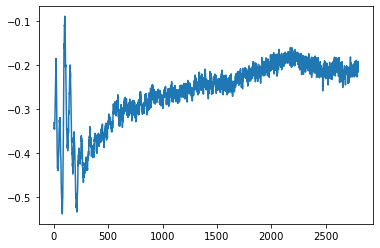

In [47]:
plt.plot(losses)
plt.show()

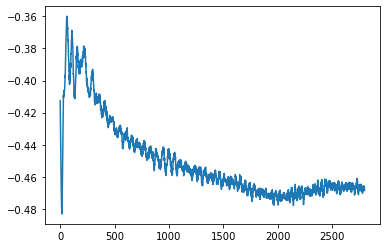

In [48]:
plt.plot(tranformed_privacies)
plt.show()

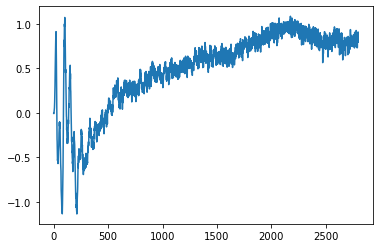

In [49]:
plt.plot(original_losses)
plt.show()

In [50]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [51]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [52]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.20596972]


## Fidelity

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

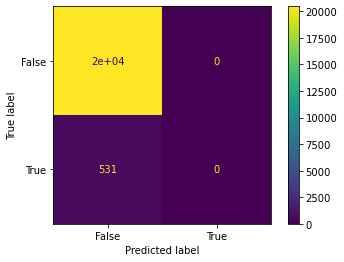

In [54]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [55]:
percentage, same_pred, dif_pred = eval_fidelity(rr_pred, fr_pred)

In [56]:
print(same_pred, dif_pred)

20469 531


## Final plot

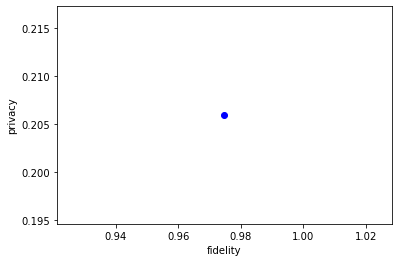

In [57]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()